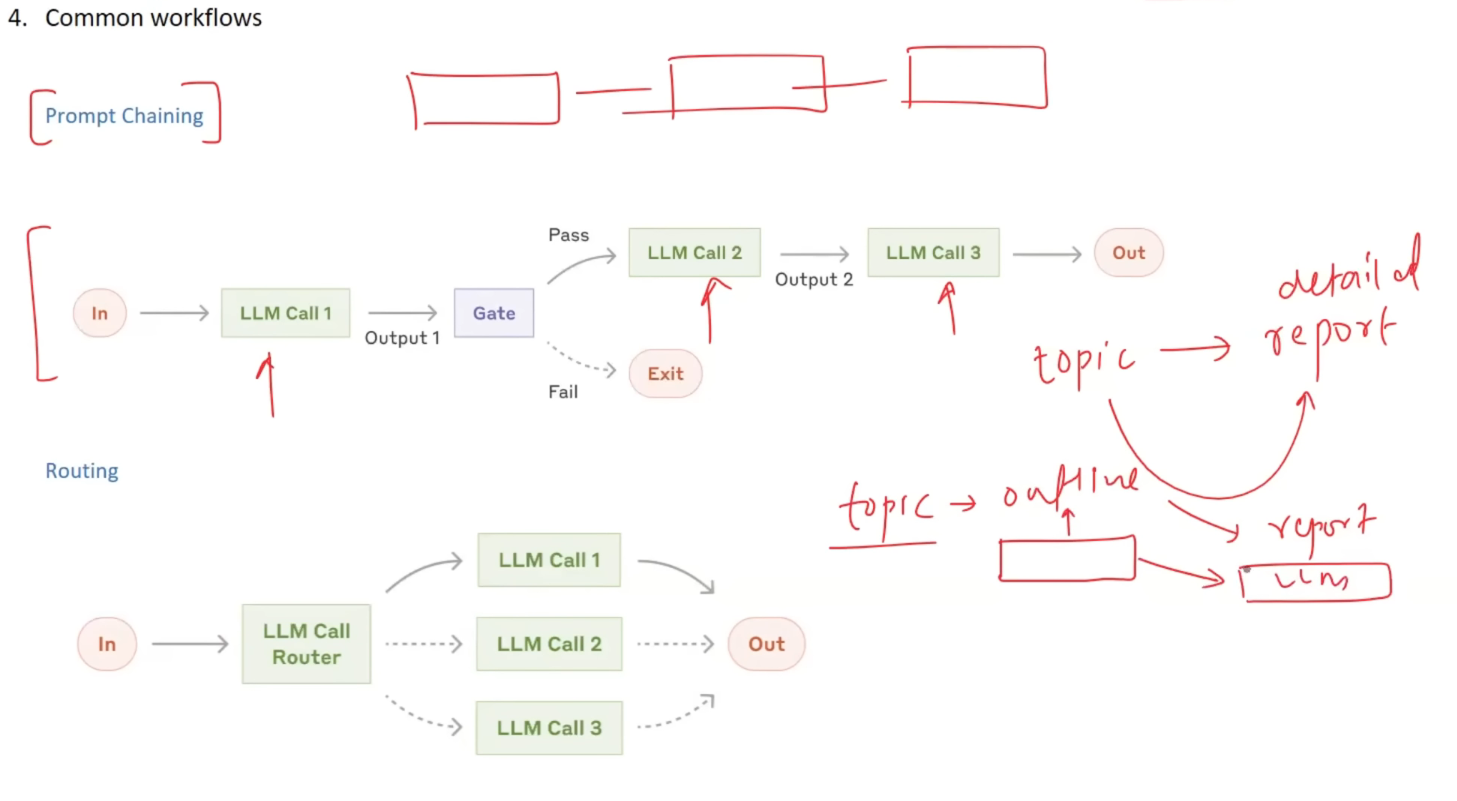

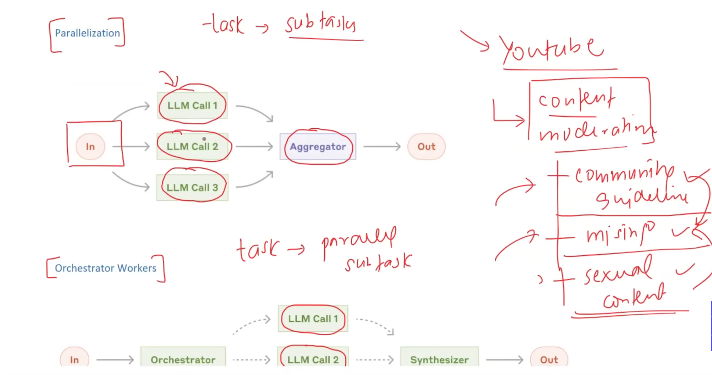

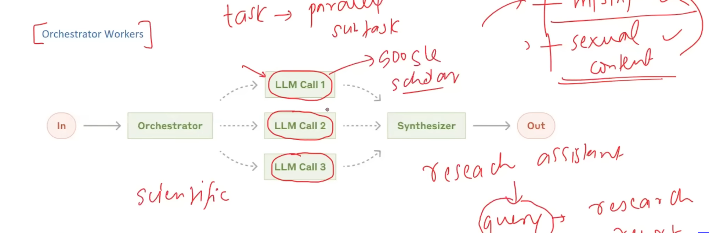

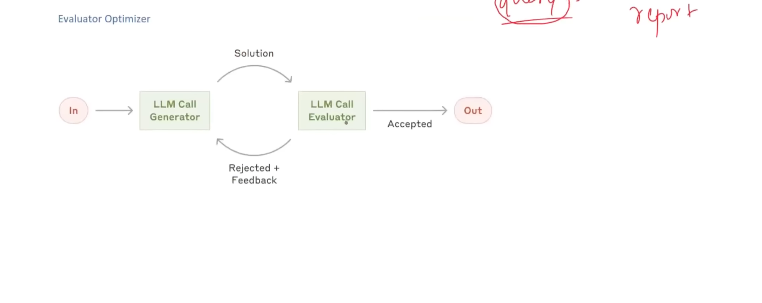

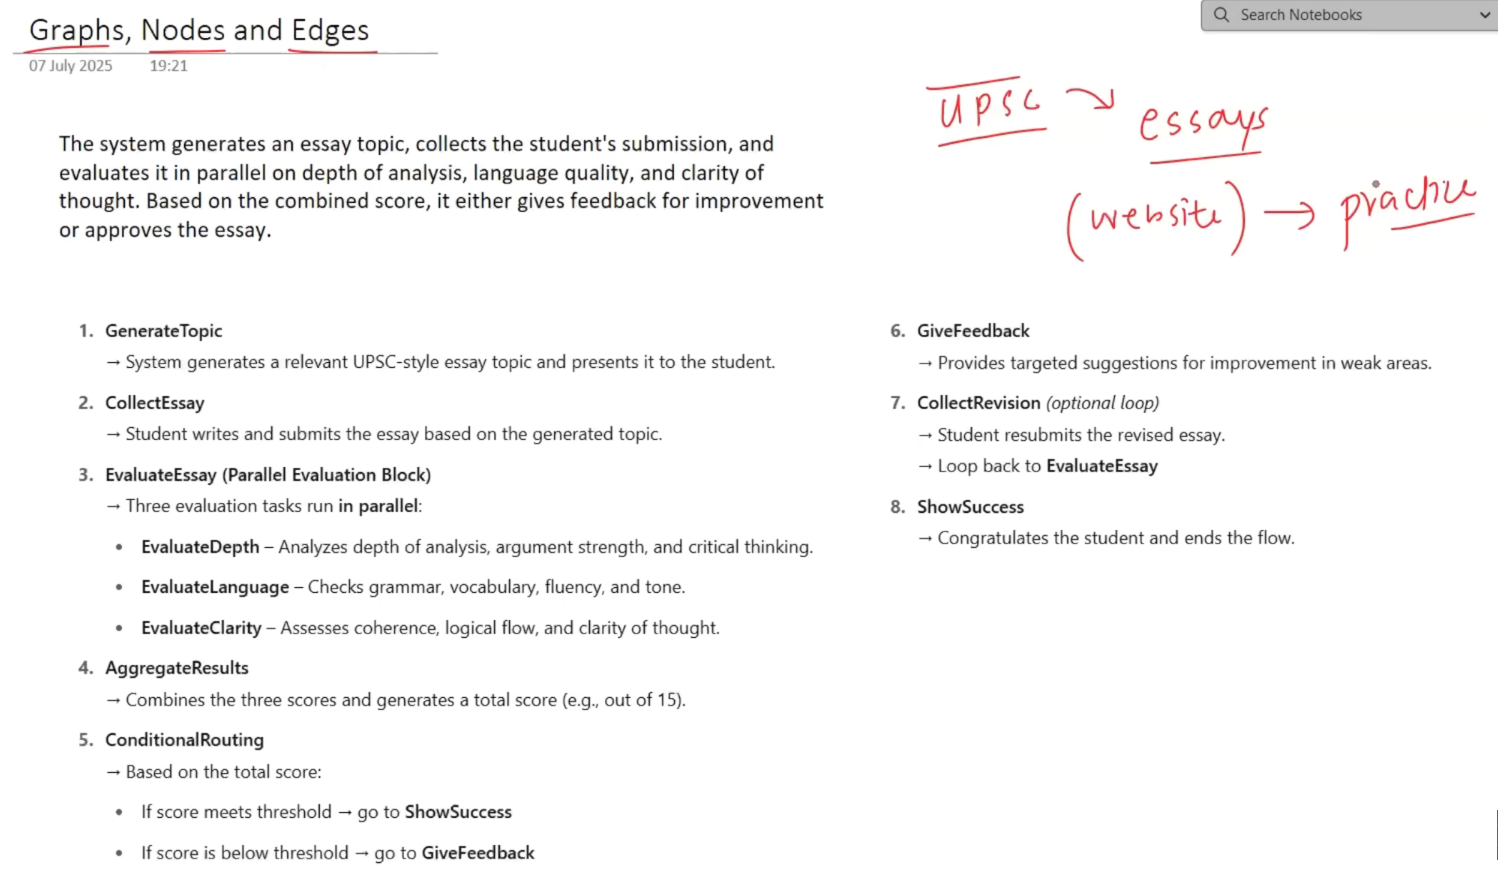

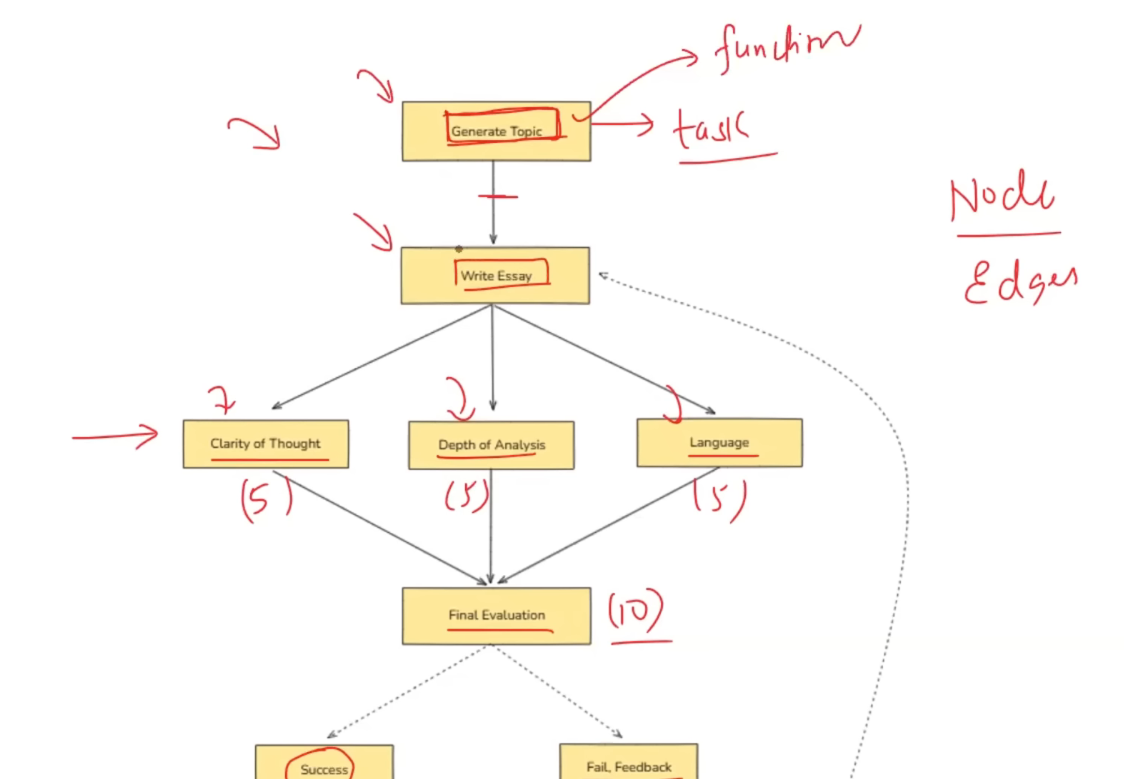

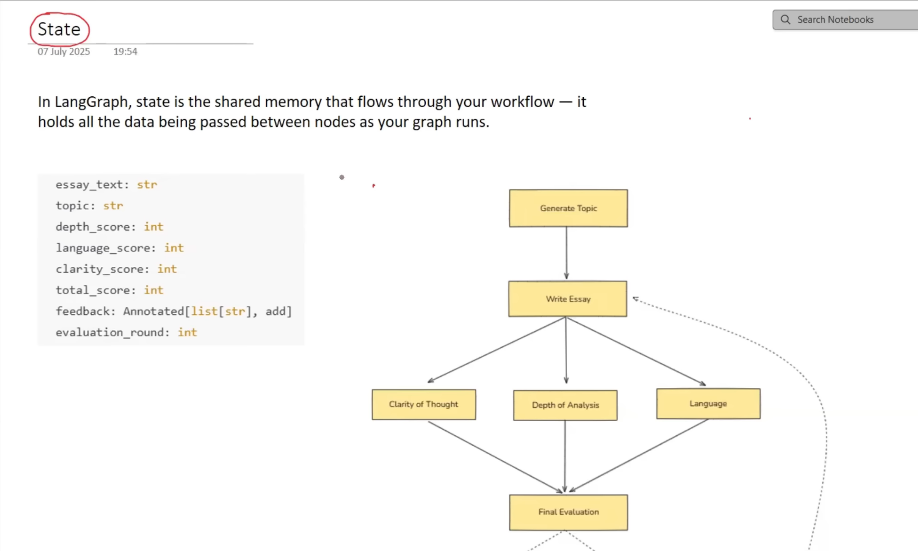

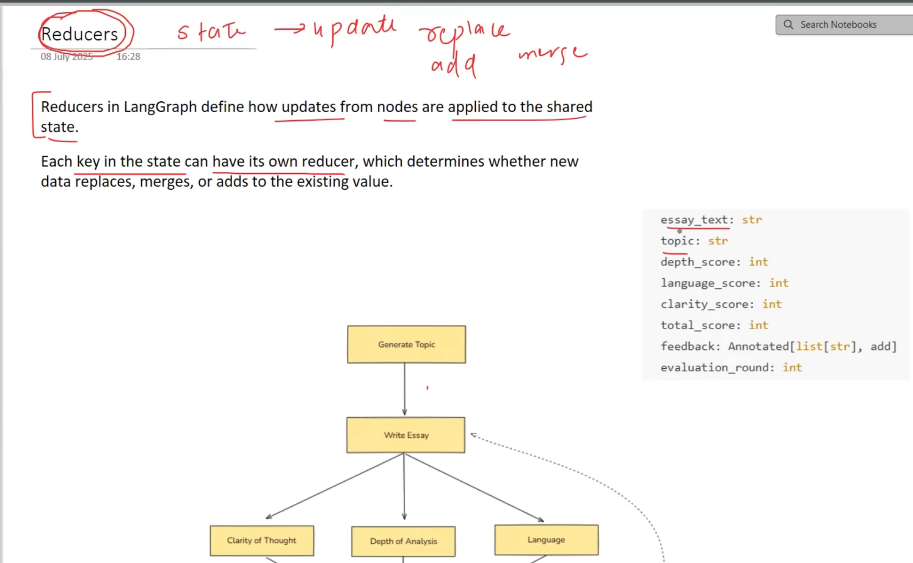

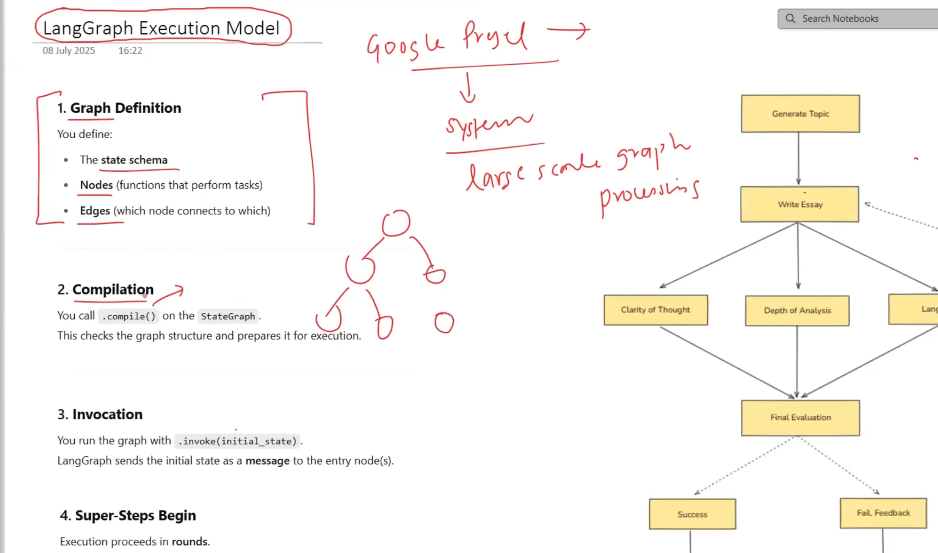

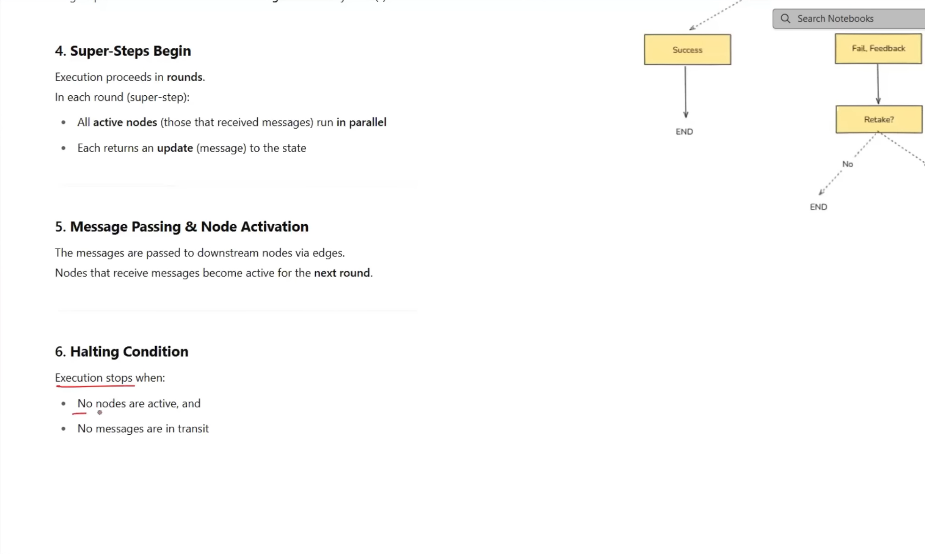


---

## LangGraph Architecture: Precise Mental Model

![Image](https://miro.medium.com/v2/resize%3Afit%3A1200/0%2Afmk9z4CULIH1fd9w.png)

![Image](https://miro.medium.com/v2/1%2AI4h8yCIrH_ZPDAjGPAfOFQ.png)

![Image](https://cdn.prod.website-files.com/66bb3d1f468f0f3848a20a84/67a4490c601ee406705fe21e_stateful_agents.webp)

![Image](https://www.doc.ic.ac.uk/~nuric/posts/sysadmin/how-does-google-pregel-work/pregel_diagram.svg)

### 1. LLM Workflows as Directed State Machines

A LangGraph workflow is a **directed graph with mutable shared state**, not a simple pipeline. Each node is a deterministic Python callable:

```
(state: StateType) -> PartialStateUpdate
```

Execution order is not implicit in code order but **explicitly encoded in graph edges**. This makes control flow auditable, debuggable, and resumable.

Supported control-flow primitives are first-class:

* Linear chains
* Fan-out / fan-in parallelism
* Conditional routing
* Cycles with explicit termination criteria

This moves LLM systems from “scripts that call models” to **state machines with bounded execution semantics**.

---

### 2. Nodes: Pure Functions with Side-Effect Discipline

A node:

* Receives the **entire current state**
* Produces **only the fields it intends to modify**
* Never mutates state in place

This functional discipline is critical for:

* Deterministic replay
* Fault recovery
* Parallel superstep execution

Nodes may call:

* LLMs
* Tools
* External services

But their observable effect is limited to returned state deltas.

---

### 3. Edges: Explicit Control and Conditional Activation

Edges define **when** a node becomes eligible to run.

There are two edge classes:

* **Static edges**: unconditional transitions
* **Conditional edges**: routing based on a selector function over state

Routing logic is separated from task logic, preventing decision-making from being hidden inside prompts or tool calls.

---

### 4. State: Typed, Reducible, and Append-Safe

State is a strongly typed structure (TypedDict or Pydantic model). Every field has:

* A type
* A reducer

Reducers define **merge semantics** when multiple nodes write to the same field in the same superstep.

Typical reducers:

* `last_value`: overwrite
* `append`: accumulate (e.g., message history)
* `merge`: structured combination

This is what enables **true parallel execution without race conditions**.

---

### 5. Execution Model: Pregel-Style Supersteps

LangGraph’s runtime follows a model derived from Google Pregel:

**Superstep**

* All currently active nodes execute concurrently
* Each emits state updates
* Reducers merge updates
* Edge conditions are evaluated
* Next active set is determined

Termination occurs only when:

* No nodes are active
* No messages remain in transit

This guarantees:

* Bounded execution
* No hidden recursion
* Observable convergence

---

### 6. Mapping to Common LLM Patterns

| Pattern             | Graph Representation             |
| ------------------- | -------------------------------- |
| Prompt chaining     | Linear path                      |
| Routing             | Conditional edges                |
| Parallelization     | Fan-out + reducer                |
| Orchestrator-worker | Dynamic fan-out driven by state  |
| Evaluator-optimizer | Explicit cycle with quality gate |

All of these are **graph shapes**, not coding tricks.

---

### 7. Why This Matters Architecturally

LangGraph solves problems that emerge only at scale:

* Non-deterministic control flow
* Hidden loops in prompt logic
* Inability to pause/resume execution
* Impossible-to-debug agent behavior

By externalizing control flow into a graph:

* Reasoning becomes inspectable
* State evolution is traceable
* Execution is replayable and testable

---

### Summary Model (One Sentence)

LangGraph treats LLM systems as **distributed state machines**, where Python functions are vertices, typed state is the message bus, reducers provide concurrency safety, and execution proceeds in deterministic supersteps until convergence.

